In [2]:
import numpy as np
import xarray as xr
import tqdm

import matplotlib.pyplot as plt

In [3]:
U_dum_stat = np.array([0.53, 0.9, -0.1, 0.1])

In [4]:
def U_interp(x, field = U_dum_stat, dx=1/4):
    "Spatial interpolation of the velocity field."
    X_idx = int(np.floor(x / dx))
    xidx_max = field.size
    U0 = field[X_idx % xidx_max]
    U1 = field[(X_idx + 1) % xidx_max]

    U_interpolated = U0 + (x - X_idx * dx) * (U1-U0)/dx
    return U_interpolated

In [5]:
def rk4_dummy(X, T, dt, dx=0.25, return_all=False, U_field=U_dum_stat):
    k1 = U_interp(x=X, dx=dx, field=U_field)
    k2 = U_interp(x=X + 0.5 * dt * k1, dx=dx, field=U_field)
    k3 = U_interp(x=X + 0.5 * dt * k2, dx=dx, field=U_field)
    k4 = U_interp(x=X + dt * k3, dx=dx, field=U_field)
    X_new = X + dt * (k1 + 2*k2 + 2*k3 + k4) / 6

    return X_new

In [6]:
def rk4_loop(x0, T0, dt, dx=0.25, dT=1, n_steps=1, U_field=U_dum_stat):
    x_rk4 = np.zeros(n_steps + 1)
    T = np.zeros(n_steps + 1)
    x_rk4[0] = x0
    T[0] = T0

    for i in range(n_steps):
        x_rk4[i+1] = rk4_dummy(x_rk4[i], T[i], dt=dt, dx=dx, U_field=U_field)
        T[i+1] = T[i] + dt
    return x_rk4, T

In [8]:
def find_next_position(x_t0, U_field, dx=1, dt_max=np.inf, atol=1e-10):
    xidx_max = U_field.size
    XG_idx = int(np.floor(x_t0 / dx))

    U0 = U_field[XG_idx % xidx_max]
    # If at the cell boundary, check if the velocity is negative. If so, decrease the index by 1 (boundary is 'right' neighbor)

    decrease_XG = 0
    if np.abs(x_t0 % dx) < atol or np.abs(x_t0 % dx - dx) < atol:
        if U0 > 0:
            pass
        else:
            decrease_XG = 1
    
    if decrease_XG:
        XG_idx -= decrease_XG
        U0 = U_field[XG_idx % xidx_max]

    U1 = U_field[(XG_idx + 1) % xidx_max]

    # print(f"{U0=}, {U1=}")

    alpha_x = -(U1 - U0)/dx
    beta_x = (XG_idx) * (U1 - U0) - U0  # Note that XG_idx is X_left_cell/dx
    
    # X-direction
    if x_t0 % dx == 0:                  # Coming through the U-wall
        if x_t0 // dx == XG_idx:        # Coming from the left
            x_t1 = (XG_idx + 1) * dx
        elif x_t0 // dx == XG_idx + 1:  # Coming from the right
            x_t1 = (XG_idx) * dx
        else:
            raise ValueError("Invalid x_t0")
    else:                               # Coming through the V-wall
        x_t1 = (int(np.sign(U0 + (x_t0%dx)/dx * (U1 - U0))/2 + 0.5) + XG_idx) * dx
    
    if alpha_x == 0:
        t1_x = (x_t0 - x_t1) / beta_x
    else:
        Fx1 = (x_t1 + beta_x/alpha_x)
        Fx0 = (x_t0 + beta_x/alpha_x)
        if np.sign(Fx1) != np.sign(Fx0):
            # Zero transport somewhere in the box
            t1_x = np.inf
        else:
            t1_x = - 1/alpha_x * np.log(Fx1/Fx0)
            if t1_x < 0:
                t1_x = np.inf

    dt = min([t1_x, np.float64(dt_max)])

   
    if t1_x < np.float64(dt_max):
        dt = t1_x
    else:
        dt = dt_max
        x_t1 = (x_t0 + beta_x/alpha_x) * np.exp(-alpha_x * dt) - beta_x/alpha_x

    return x_t1, dt

In [9]:
def modcorr(v, m, eps=1e-15):
    """
    Compute the remainder of the division of v by m, with a tolerance eps.

    Parameters
    ----------
    v : float
        Dividend.
    m : float
        Divisor.

    Returns
    -------
    r : float
        Remainder of the division of v by m.
    
    """
    r = v % m
    if np.abs(r - m) < eps:
        r = 0
    if np.abs(r) < eps:
        r=0
    return r

In [12]:
def loop_analytical(x0, t0, T_end, dt, dx=1, atol=1e-10, U=U_dum_stat, reverse=False):
    assert np.abs(T_end % dt) < 1e-10 or np.abs(T_end % dt - dt) < atol
    nT = abs(int(np.round(np.abs(T_end - t0) / dt)))

    X = [x0]
    T = [t0]

    dt_reciprocal = 1/dt

    timer = t0

    keepgoing = True
    maxiter = 100
    iternum = 0

    while keepgoing:
        if reverse:
            U = -U

        dt_max = ((timer * dt_reciprocal) // (dt * dt_reciprocal) + 1) * dt - timer
        x_new, step_dt = find_next_position(X[-1], U, dx=dx, dt_max = dt_max) # edit for dynamic
        timer += step_dt

        if np.abs(timer % np.abs(dt) - np.abs(dt)) < atol or np.abs(timer % np.abs(dt)) < atol:
            timer = np.round(np.round(timer / np.abs(dt)) * np.abs(dt), 5)

        X.append(x_new)
        T.append(timer)

        iternum += 1
        if iternum >= maxiter:
            keepgoing = False
        if dt > 0:
            if timer >= T_end:
                keepgoing = False
        elif dt < 0:
            if timer <= T_end or np.isclose(timer, T_end):
                keepgoing = False
    return X, T


Text(0, 0.5, 'Space')

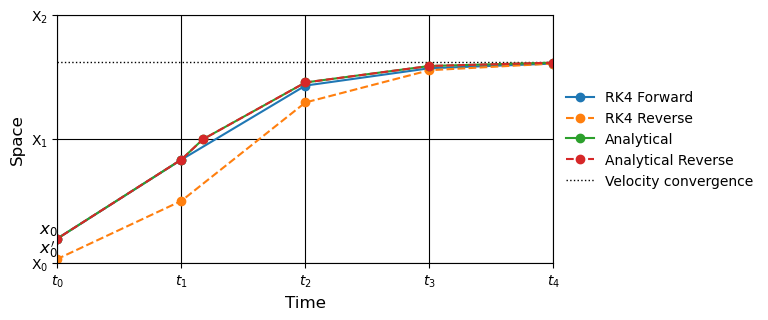

In [13]:
# U_dum_stat = np.array([0.53, 0.9, -0.1, 0.1])
U_dum_stat = np.array([0.3, 1, -0.6, 0.1])
n_steps = 4
dt = 0.25
x0 = 0.05

x_rk4, T_rk4 = rk4_loop(x0=x0, T0=0, dt=dt, dx=0.25, n_steps=n_steps, U_field=U_dum_stat)
x_rk4_reverse, T_rk4_reverse = rk4_loop(x0=x_rk4[-1], T0=T_rk4[-1], dt=-dt, dx=0.25, n_steps=n_steps, U_field=U_dum_stat)
X_anal, T_anal = loop_analytical(x0, t0=0, T_end=0.25*n_steps, dt=dt, dx=0.25, U=U_dum_stat)
X_anal_reverse, T_anal_reverse = loop_analytical(X_anal[-1], t0=0, T_end=0.25*n_steps, dt=dt, dx=0.25, U=-U_dum_stat)

fig, ax = plt.subplots()

ax.plot(T_rk4, x_rk4, marker='o', label="RK4 Forward")
ax.plot(T_rk4_reverse, x_rk4_reverse, marker='o', label="RK4 Reverse", linestyle='dashed')
ax.plot(T_anal, X_anal, marker='o', label="Analytical")
ax.plot(dt * n_steps -np.array(T_anal_reverse), X_anal_reverse, marker='o', label="Analytical Reverse", linestyle='dashed')

ax.text(0, x_rk4[0], "$x_0$", fontsize=12, ha='right', va="bottom")
ax.text(0, x_rk4_reverse[-1], "$x_0'$", fontsize=12, ha='right', va="bottom")

ax.set_aspect('equal')

ax.set_ylim(0, 0.5)
ax.set_xticks(np.arange(0, 1.1, 0.25))
ax.set_yticks(np.arange(0, 0.51, 0.25))
ax.grid(color='black')

ax.axhline(0.25 + 0.25 * 1/(1+0.6), color='k', linestyle='dotted', linewidth=1, zorder=0, label="Velocity convergence")

# for i in range(5):
    # ax.axvline(i/4, color='k', linestyle='--', linewidth=1, zorder=0)
    # ax.axhline(i/4, color='k', linestyle='--', linewidth=1, zorder=0)
ax.set_xlim(0, dt*n_steps)
# no legend box
ax.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', frameon=False)
ax.set_xticklabels(["$t_0$", "$t_1$", "$t_2$", "$t_3$", "$t_4$"])
ax.set_yticklabels(['X$_0$', 'X$_1$', 'X$_2$'])
plt.xlabel("Time", size='large')
plt.ylabel("Space", size='large')
# plt.savefig("idealized_example.pdf", bbox_inches='tight')

In [15]:
def x_t_horiz(t, x0, X0=0, U0=0.05, U1=None, dx = 1e4):
    if U1 is None:
        U1 = - U0

    return X0 + (U0 * dx - np.exp((t * (U1 - U0)) / dx) * ((U1 - U0) * (x0 - X0) + U0 * dx)) / (U0 - U1)

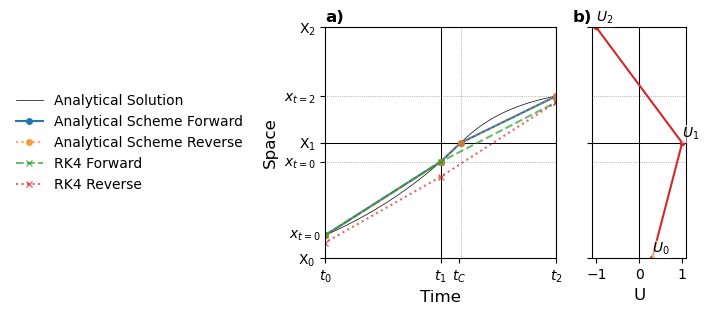

In [33]:
U_dum_stat = np.array([0.3, 1, -1, 0.1])
n_steps = 2
dt = 0.25
x0 = 0.05

x_rk4, T_rk4 = rk4_loop(x0=x0, T0=0, dt=dt, dx=0.25, n_steps=n_steps, U_field=U_dum_stat)
x_rk4_reverse, T_rk4_reverse = rk4_loop(x0=x_rk4[-1], T0=T_rk4[-1], dt=-dt, dx=0.25, n_steps=n_steps, U_field=U_dum_stat)
X_anal, T_anal = loop_analytical(x0, t0=0, T_end=0.25*n_steps, dt=dt, dx=0.25, U=U_dum_stat)
X_anal_reverse, T_anal_reverse = loop_analytical(X_anal[-1], t0=0, T_end=0.25*n_steps, dt=dt, dx=0.25, U=-U_dum_stat)
plt.rcParams['text.usetex'] = False
fig = plt.figure(figsize=(5,3))
gs = fig.add_gridspec(1, 2, width_ratios=[3, 1], wspace=0.05)
ax = fig.add_subplot(gs[0])

# True analytical
an_t_leg1 = np.arange(0, T_anal[2], 0.01)
an_x_leg1 = x_t_horiz(an_t_leg1, x0=0.05, U0=U_dum_stat[0], U1=U_dum_stat[1], dx= 0.25)
an_t_leg2 = np.arange(0, 1 - T_anal[2], 0.01)
an_x_leg2 = x_t_horiz(an_t_leg2, x0=0, U0=U_dum_stat[1], U1=U_dum_stat[2], dx= 0.25)
ax.plot(an_t_leg1, an_x_leg1, color='black',label="Analytical Solution", linewidth=0.5)
ax.plot(an_t_leg2 + T_anal[2], an_x_leg2 + 0.25, color='black', linewidth=0.5)

ax.plot(T_anal, X_anal, marker='o', label="Analytical Scheme Forward",  markersize=4)
ax.plot(dt * n_steps -np.array(T_anal_reverse), X_anal_reverse, marker='o', label="Analytical Scheme Reverse", linestyle='dotted', alpha=0.7, markersize=4)
ax.plot(T_rk4, x_rk4, marker='x', label="RK4 Forward", linestyle='dashed', markersize=4, alpha=0.7)
ax.plot(T_rk4_reverse, x_rk4_reverse, marker='x', label="RK4 Reverse", linestyle='dotted', alpha=0.7, markersize=4)



ax.set_aspect('equal')
ax.set_ylim(0, 0.5)
ax.set_xticks([0, 0.25, an_t_leg1[-1], 0.5])
ax.set_xticklabels(["$t_0$", "$t_1$", "$t_C$", "$t_2$"])
ax.set_yticks([0, X_anal[1], 0.25, X_anal[3], 0.5])
# ax.set_yticks(np.arange(0, 0.51, 0.25))
ax.set_yticklabels(['X$_0$', '$x_{t=0}$', 'X$_1$', '$x_{t=2}$','X$_2$'])
# ax.set_yticklabels(['$\mathrm{X_0}$', '$\mathrm{X_1}$', '$\mathrm{X_2}$'])
ax.axhline(0.25, color='black', linewidth=0.75, zorder=0)
ax.axvline(0.25, color='black', linewidth=0.75, zorder=0)
# ax.axvline(T_anal[2], color='black', linewidth=0.75, zorder=0, linestyle='dotted')
# ax.axhline(X_anal[1], color='black', linewidth=0.75, zorder=0, linestyle='dotted')
# ax.axhline(X_anal[3], color='black', linewidth=0.75, zorder=0, linestyle='dotted')
ax.axvline(T_anal[2], color='grey', linewidth=0.5, zorder=0, linestyle='dotted')
ax.axhline(X_anal[1], color='grey', linewidth=0.5, zorder=0, linestyle='dotted')
ax.axhline(X_anal[3], color='grey', linewidth=0.5, zorder=0, linestyle='dotted')

# ax.grid(color='black')
ax.text(-0.01, x_rk4[0], "$x_{t=0}$", fontsize=10, ha='right', va="center")

ax.set_xlim(0, dt*n_steps)

ax.legend(bbox_to_anchor=(-0.3, 0.5), loc='center right', frameon=False)


ax.set_xlabel("Time", size='large')
ax.set_ylabel("Space", size='large')
ax.text(0, 1.01, "a)", fontsize=12, ha='left', va='bottom', fontweight='bold', transform=ax.transAxes)

ax2 = fig.add_subplot(gs[1])
ax2.plot(U_dum_stat[:3], np.arange(0,0.51, 0.25), marker='.', color='C3')

for i in range(3):
    ax2.text(U_dum_stat[i], i*0.25+0.02, f"$U_{i}$", fontsize=10, ha='left', va='center', bbox=dict(facecolor='white', edgecolor='white', pad=0, alpha=0.5))

ax2.set_yticks(np.arange(0, 0.51, 0.25))
ax2.set_ylim(0, 0.5)
ax2.set_xlabel("U", size='large')
ax2.axhline(0.25, color='black', linewidth=0.75, zorder=0)
ax2.axvline(0, color='black', linewidth=0.75, zorder=0)
ax2.set_yticklabels([])
ax2.axhline(X_anal[1], color='grey', linewidth=0.5, zorder=0, linestyle='dotted')
ax2.axhline(X_anal[3], color='grey', linewidth=0.5, zorder=0, linestyle='dotted')
ax2.text(0, 1.01, "b)", fontsize=12, ha='right', va='bottom', fontweight='bold', transform=ax2.transAxes)
# plt.tight_layout()

plt.savefig("idealized_example.pdf", bbox_inches='tight')